# Project : Spam/Ham Classification
## Feature Engineering, Logistic Regression, Cross Validation


In this project, I will create a classifier that can distinguish spam (junk or commercial or bulk) emails from ham (non-spam) emails.

### Summary of this project:

- Feature engineering with text data
- Using sklearn libraries to process data and fit models
- Validating the performance of your model and minimizing overfitting
- Generating and analyzing precision-recall curves

### Conclusion
- trained the regression model so that the classification yielded around 95% accuracy with the test data

# Part I - Initial Analysis

In [229]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set(style = "whitegrid", 
        color_codes = True,
        font_scale = 1.5)

### Loading in the Data

In email classification, the goal is to classify emails as spam or not spam (referred to as "ham") using features generated from the text in the email. 

The dataset consists of email messages and their labels (0 for ham, 1 for spam). The labeled training dataset contains 8348 labeled examples, and the test set contains 1000 unlabeled examples.

I will run the following cells to load in the data into DataFrames.

The `train` DataFrame contains labeled data that I will use to train my model. It contains four columns:

1. `id`: An identifier for the training example
1. `subject`: The subject of the email
1. `email`: The text of the email
1. `spam`: 1 if the email is spam, 0 if the email is ham (not spam)

The `test` DataFrame contains 1000 unlabeled emails. I will predict labels for these emails and submit my predictions to Kaggle for evaluation.

In [1]:
from utils import fetch_and_cache_gdrive
fetch_and_cache_gdrive('1SCASpLZFKCp2zek-toR3xeKX3DZnBSyp', 'train.csv')
fetch_and_cache_gdrive('1ZDFo9OTF96B5GP2Nzn8P8-AL7CTQXmC0', 'test.csv')

original_training_data = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

# Convert the emails to lower case as a first step to processing the text
original_training_data['email'] = original_training_data['email'].str.lower()
test['email'] = test['email'].str.lower()

original_training_data.head()

ModuleNotFoundError: No module named 'utils'


First, I checked if our data contains any missing values. 
I filled in the cell below to print the number of NaN values in each column and replaced them with appropriate filler values (i.e., NaN values in the `subject` or `email` columns should be replaced with empty strings). After, I printed the number of NaN values in each column after this modification to verify that there are no NaN values left.

Note that while there are no NaN values in the `spam` column, we should be careful when replacing NaN labels. Doing so without consideration may introduce significant bias into our model when fitting.

In [231]:
print(original_training_data.isnull().sum())
original_training_data = original_training_data.fillna(value='')
print(original_training_data.isnull().sum())

id         0
subject    6
email      0
spam       0
dtype: int64
id         0
subject    0
email      0
spam       0
dtype: int64




I printed the text of the first ham and the first spam email in the original training set.


In [233]:
first_ham = original_training_data[original_training_data['spam'] == 0]['email'].iloc[0]
first_spam = original_training_data[original_training_data['spam'] == 1]['email'].iloc[0]
print(first_ham)
print(first_spam)

url: http://boingboing.net/#85534171
 date: not supplied
 
 arts and letters daily, a wonderful and dense blog, has folded up its tent due 
 to the bankruptcy of its parent company. a&l daily will be auctioned off by the 
 receivers. link[1] discuss[2] (_thanks, misha!_)
 
 [1] http://www.aldaily.com/
 [2] http://www.quicktopic.com/boing/h/zlfterjnd6jf
 
 

<html>
 <head>
 </head>
 <body>
 <font size=3d"4"><b> a man endowed with a 7-8" hammer is simply<br>
  better equipped than a man with a 5-6"hammer. <br>
 <br>would you rather have<br>more than enough to get the job done or fall =
 short. it's totally up<br>to you. our methods are guaranteed to increase y=
 our size by 1-3"<br> <a href=3d"http://209.163.187.47/cgi-bin/index.php?10=
 004">come in here and see how</a>
 </body>
 </html>
 
 
 



The ham emails contains links that are related to the content of the email (to support or refer to what they are talking about in the email). 
<br>
The spam emails uses second person pronoun that directs to the person recieving the email direction. E.g. 'would you rather', 'it's toally up to you'. It also contains promotional language such as 'better', guaranteed to increase'.
<br>
Moreover, we also notice that the spam email is contains html tags and its length is longer than the ham email. Moreover, it seems to contain more punctuations and capital letters



## Training Validation Split
The training data I downloaded is all the data I have available for both training models and **validating** the models that i train.  
I therefore need to split the training data into separate training and validation datsets.  
I will need this **validation data** to assess the performance of my classifier once I am finished training. 

In [235]:
from sklearn.model_selection import train_test_split

train, val = train_test_split(original_training_data, test_size=0.1, random_state=42)

# Basic Feature Engineering

We would like to take the text of an email and predict whether the email is ham or spam. This is a *classification* problem, so we can use logistic regression to train a classifier. Recall that to train an logistic regression model we need a numeric feature matrix $X$ and a vector of corresponding binary labels $y$.  Unfortunately, our data are text, not numbers. To address this, we can create numeric features derived from the email text and use those features for logistic regression.

Each row of $X$ is an email. Each column of $X$ contains one feature for all the emails.I will start by creating a simple feature, and create more interesting ones when I am trying to increase accuracy.

Created a function called `words_in_texts` that takes in a list of `words` and a pandas Series of email `texts`. 
It should output a 2-dimensional NumPy array containing one row for each email text. The row should contain either a 0 or a 1 for each word in the list: 0 if the word doesn't appear in the text and 1 if the word does. For example:

```
>>> words_in_texts(['hello', 'bye', 'world'], 
                   pd.Series(['hello', 'hello worldhello']))

array([[1, 0, 0],
       [1, 0, 1]])
```



In [236]:
words = ['hello', 'bye', 'world'] 
texts = pd.Series(['hello', 'hello worldhello'])

In [237]:
def words_in_texts(words, texts):
    '''
    Args:
        words (list-like): words to find
        texts (Series): strings to search in
    
    Returns:
        NumPy array of 0s and 1s with shape (n, p) where n is the
        number of texts and p is the number of words.
    '''
    indicator_array = []
    for x in texts:
        num_array = []
        for y in words:
            if y in x:
                num_array = np.append(num_array, 1)
            else:
                num_array = np.append(num_array, 0)
        indicator_array = np.append(indicator_array, num_array)
    indicator_array = np.reshape(indicator_array, (len(texts),len(words)))
    indicator_array = indicator_array.astype(int)
    return indicator_array
words_in_texts(words, texts)

array([[1, 0, 0],
       [1, 0, 1]])

In [238]:
words_in_texts(words, texts)

array([[1, 0, 0],
       [1, 0, 1]])

# Basic EDA

We need to identify some features that allow us to distinguish spam emails from ham emails. One idea is to compare the distribution of a single feature in spam emails to the distribution of the same feature in ham emails. If the feature is itself a binary indicator, such as whether a certain word occurs in the text, this amounts to comparing the proportion of spam emails with the word to the proportion of ham emails with the word.


The following plot (which was created using `sns.barplot`) compares the proportion of emails in each class containing a particular set of words. 



In [240]:
from IPython.display import display, Markdown
df = pd.DataFrame({
    'word_1': [1, 0, 1, 0],
    'word_2': [0, 1, 0, 1],
    'type': ['spam', 'ham', 'ham', 'ham']
})
display(Markdown("> Our Original DataFrame has some words column and a type column. You can think of each row as a sentence, and the value of 1 or 0 indicates the number of occurances of the word in this sentence."))
display(df);
display(Markdown("> `melt` will turn columns into variale, notice how `word_1` and `word_2` become `variable`, their values are stored in the value column"))
display(df.melt("type"))

> Our Original DataFrame has some words column and a type column. You can think of each row as a sentence, and the value of 1 or 0 indicates the number of occurances of the word in this sentence.

,word_1,word_2,type
0,1,0,spam
1,0,1,ham
2,1,0,ham
3,0,1,ham


> `melt` will turn columns into variale, notice how `word_1` and `word_2` become `variable`, their values are stored in the value column

,type,variable,value
0,spam,word_1,1
1,ham,word_1,0
2,ham,word_1,1
3,ham,word_1,0
4,spam,word_2,0
5,ham,word_2,1
6,ham,word_2,0
7,ham,word_2,1




Create a bar chart like the one above comparing the proportion of spam and ham emails containing certain words. Choose a set of words that are different from the ones above, but also have different proportions for the two classes. Make sure to only consider emails from `train`.


Text(0, 0.5, 'Words')

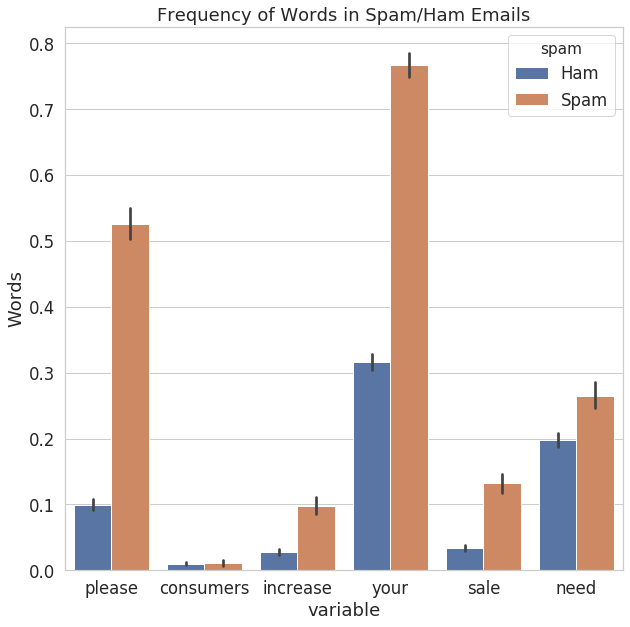

In [241]:
train=train.reset_index(drop=True) # We must do this in order to preserve the ordering of emails to labels for words_in_texts
text = train['email']
words = ['please', 'consumers', 'increase', 'your', 'sale', 'need']
words_table = pd.DataFrame(words_in_texts(words, text), columns = words)
train_merged = train.merge(words_table, left_index = True, right_index = True)
train_merged = train_merged.drop(columns = ['id', 'subject', 'email'])
train_melted = train_merged.melt('spam')
train_melted['spam'] = train_melted['spam'].replace(1, 'Spam')
train_melted['spam'] = train_melted['spam'].replace(0, 'Ham')
plt.figure(figsize=(10,10))
ax = sns.barplot(x='variable', y='value', hue = 'spam', data = train_melted)
ax.set_title('Frequency of Words in Spam/Ham Emails')
ax.set_ylabel('Words')

When the feature is binary, it makes sense to compare its proportions across classes (as in the previous question). Otherwise, if the feature can take on numeric values, we can compare the distributions of these values for different classes. 


Create a *class conditional density plot* like the one above (using `sns.distplot`), comparing the distribution of the length of spam emails to the distribution of the length of ham emails in the training set. Set the x-axis limit from 0 to 50000.

<!--
BEGIN QUESTION
name: q3b
manual: True
format: image
points: 2
-->
<!-- EXPORT TO PDF format:image -->

(0, 50000)

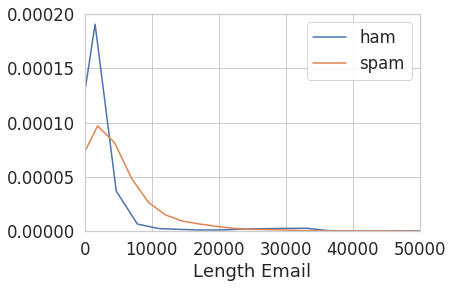

In [242]:
train['Length Email'] = train['email'].str.len()
train_ham = train.loc[train['spam'] == 0]
train_spam = train.loc[train['spam'] == 1]
plt.clf()
sns.distplot(train_ham['Length Email'], hist = False, label = 'ham')
sns.distplot(train_spam['Length Email'], hist = False, label = 'spam')
plt.legend()
plt.xlim(0, 50000)

# Basic Classification

Notice that the output of `words_in_texts(words, train['email'])` is a numeric matrix containing features for each email. This means we can use it directly to train a classifier!



I've started with 5 words that might be useful as features to distinguish spam/ham emails. Use these words as well as the `train` DataFrame to create two NumPy arrays: `X_train` and `Y_train`.

`X_train` should be a matrix of 0s and 1s created by using your `words_in_texts` function on all the emails in the training set.

`Y_train` should be a vector of the correct labels for each email in the training set.


In [243]:
some_words = ['drug', 'bank', 'prescription', 'memo', 'private']

X_train = words_in_texts(some_words, train['email'])
Y_train = train['spam']
x_test =  words_in_texts(some_words, val['email'])
y_test = val['spam']
X_train[:5], Y_train[:5]

(array([[0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0]]), 0    0
 1    0
 2    0
 3    0
 4    0
 Name: spam, dtype: int64)

Now that we have matrices, we can use to scikit-learn! Using the [`LogisticRegression`](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) classifier, train a logistic regression model using `X_train` and `Y_train`. Then, output the accuracy of the model (on the training data) in the cell below. You should get an accuracy around 0.75.



In [245]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
model.fit(X_train, Y_train)

training_accuracy = model.score(X_train, Y_train)
print("Training Accuracy: ", training_accuracy)

Training Accuracy:  0.7576201251164648


## Evaluating Classifiers

That doesn't seem too shabby! But the classifier I made above isn't as good as this might lead us to believe. First, we are evaluating accuracy on the training set, which may provide a misleading accuracy measure, especially if we used the training set to identify discriminative features. In future parts of this analysis, it will be safer to hold out some of our data for model validation and comparison.

Presumably, our classifier will be used for **filtering**, i.e. preventing messages labeled `spam` from reaching someone's inbox. There are two kinds of errors we can make:
- False positive (FP): a ham email gets flagged as spam and filtered out of the inbox.
- False negative (FN): a spam email gets mislabeled as ham and ends up in the inbox.

These definitions depend both on the true labels and the predicted labels. False positives and false negatives may be of differing importance, leading us to consider more ways of evaluating a classifier, in addition to overall accuracy:

**Precision** measures the proportion $\frac{\text{TP}}{\text{TP} + \text{FP}}$ of emails flagged as spam that are actually spam.

**Recall** measures the proportion $\frac{\text{TP}}{\text{TP} + \text{FN}}$ of spam emails that were correctly flagged as spam. 

**False-alarm rate** measures the proportion $\frac{\text{FP}}{\text{FP} + \text{TN}}$ of ham emails that were incorrectly flagged as spam. 

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/2/26/Precisionrecall.svg/700px-Precisionrecall.svg.png" width="500px">

Note that a true positive (TP) is a spam email that is classified as spam, and a true negative (TN) is a ham email that is classified as ham.




Suppose we have a classifier `zero_predictor` that always predicts 0 (never predicts positive). How many false positives and false negatives would this classifier have if it were evaluated on the training set and its results were compared to `Y_train`?

In [247]:
zero_predictor_fp = 0
zero_predictor_fn = len(train[Y_train == 1])
zero_predictor_fp,zero_predictor_fn

(0, 1918)



What are the accuracy and recall of `zero_predictor` (classifies every email as ham) on the training set? Found without using scipy function

In [249]:
zero_predictor_tp = 0
zero_predictor_tn = len(train[train['spam'] == 0])
zero_predictor_acc = (zero_predictor_tp + zero_predictor_tn) / (zero_predictor_tp + zero_predictor_tn + zero_predictor_fp + zero_predictor_fn)
zero_predictor_recall =  (zero_predictor_tp)/(zero_predictor_tp + zero_predictor_fn)

zero_predictor_tp, zero_predictor_tn, zero_predictor_acc, zero_predictor_recall

(0, 5595, 0.7447091707706642, 0.0)


Provide brief explanations of the results from above. Why do we observe each of these values (FP, FN, accuracy, recall)?


FP: For False Positive, we are getting 0 because we are never predicting positive with our classifier, but always predicitng negative. 
<br>
FN: With Similar reasoning, for False Negative, we notice that the false negative, which is when prediction is 0 and truth is 1, we should just look at all the true values that are 1. Hence we get the number of rows containing spam as 1.
<br>
Accuracy: accuracy is defined by (TP+TN)/ (TP+TN+FP+FN) or (TP+TN)/n. And we know from the classifier, we should get a value of 0 for our true positive (prediction = 1 and truth = 1). Therefore, the accuracy is just the proportion of TP over all the values, i.e. TP/n. 
<br>
Recall: recall is defined by TP/ (TP+FN) and we know that the TP should be 0 in our, hence it makes sense that the recall is also zero

Compute the precision, recall, and false-alarm rate of the `LogisticRegression` classifier created and trained above without using any sklearn function



In [251]:
modelTP = np.count_nonzero(model.predict(X_train) & Y_train)
modelTN = np.count_nonzero((~model.predict(X_train)) & (~Y_train))
modelFP = np.count_nonzero(model.predict(X_train) & (~Y_train))
modelFN = np.count_nonzero((~model.predict(X_train)) & Y_train)
logistic_predictor_precision = modelTP/ (modelTP+modelFN)
logistic_predictor_recall = modelTP/ (modelTP+modelFP)
logistic_predictor_far = modelFP/ (modelFP+modelTN)
logistic_predictor_precision, logistic_predictor_recall, logistic_predictor_far

(0.11418143899895725, 0.6422287390029325, 0.015979043876882777)

There wer more false negatives (1699) than false positives (122) for the logistic regression classifier

In [253]:
modelFP, modelFN

(122, 1699)



1. Our logistic regression classifier got 75.6% prediction accuracy (number of correct predictions / total). How does this compare with predicting 0 for every email?
1. Given the word features we gave you above, name one reason this classifier is performing poorly. Hint: Think about how prevalent these words are in the email set.
1. Which of these two classifiers would you prefer for a spam filter and why? Describe your reasoning and relate it to at least one of the evaluation metrics you have computed so far.



1) the zero_predictor had the accuracy of 74.5% which is less accurate than the logisitc regression classifier. 

2) This is because the words we chose are generic for both the ham and spam emails, our false-alarm rate of the model is 1.6% which we should aim to lower. This may be able to achivable by better choice of words. 

3) Logistic regression because since the zero_prediciton model had similar accuracy with the logistic model, it does not actually catch any spam emails. No matter what the true status of the email is, we always say that they are not spam (is ham). Consequently, the zero_prediction classifier has recall and TP whereas the logistical regression has much higher value 

In [254]:
zero_predictor_tp, zero_predictor_tn, zero_predictor_acc, zero_predictor_recall

(0, 5595, 0.7447091707706642, 0.0)

# Part II - Moving Forward

With this in mind, it is now my task to make the spam filter more accurate. To see my accuracy on the test set, I will use my classifier to predict every email in the `test` DataFrame and upload your predictions to Kaggle.


Here are some ideas for improving my model:

1. Finding better features based on the email text. Some example features are:
    1. Number of characters in the subject / body
    1. Number of words in the subject / body
    1. Use of punctuation (e.g., how many '!' were there?)
    1. Number / percentage of capital letters 
    1. Whether the email is a reply to an earlier email or a forwarded email
1. Finding better (and/or more) words to use as features. Which words are the best at distinguishing emails? This requires digging into the email text itself. 
1. Better data processing. For example, many emails contain HTML as well as text. You can consider extracting out the text from the HTML to help you find better words. Or, you can match HTML tags themselves, or even some combination of the two.
1. Model selection. You can adjust parameters of your model (e.g. the regularization parameter) to achieve higher accuracy. Recall that you should use cross-validation to do feature and model selection properly! Otherwise, you will likely overfit to your training data.

 **not allowed to import any external feature extraction libraries**. In addition, **only allowed to train logistic regression models** by the rules of Kaggle competition



**Note:** *use the **validation data** to evaluate my model and get a better sense of how it will perform on the Kaggle evaluation.*

---

In [255]:
pip install wordcloud

You are using pip version 9.0.1, however version 19.3.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [256]:
import re
from bs4 import BeautifulSoup
stop = pd.read_csv('stopwords.csv', header = None)
from wordcloud import STOPWORDS as stop

In [257]:
def clean_email_remove_stop(email):
    html_parsed = BeautifulSoup(email, 'html.parser').text 
    removed_punc = re.sub(r'\s+', ' ', html_parsed) 
    cleaned_spaces = re.sub(r'[^\w\d\s]', ' ', removed_punc)  
    removed_whitespace = re.sub(r'^\s+|\s+?$', '', cleaned_spaces.lower()) 
    removed_underscore = re.sub(r'[_]*', '', removed_whitespace)
    return ' '.join(
        word for word in removed_whitespace.split() if word not in stop
    )

In [258]:
train['email_clean'] = train['email'].apply(clean_email_remove_stop)
train['email_clean'][2]

'please post link fox original message arnaud abelard sent tuesday september 03 2002 2 39 subject razor users razor plugins mozilla hello hear razor plugin mozilla plugin add report spam button somewhere user report mail spam server arnaud arnaud ablard administrateur rseaux et systmes irin facult de sciences universit de nantes sf net email sponsored osdn tired old cell phone new free https inphonic asp sourceforge1 refcode1 vs3390 _______________________________________________ razor users mailing list razor users lists sourceforge net https lists sourceforge net lists listinfo razor users sf net email sponsored osdn tired old cell phone new free https inphonic asp sourceforge1 refcode1 vs3390 _______________________________________________ razor users mailing list razor users lists sourceforge net https lists sourceforge net lists listinfo razor users'

In [259]:
#replace the underscores that I couldn't remove in through the function
train['email_clean'] = train['email_clean'].str.replace(r'[_]+', '')
train['email_clean'][2]

'please post link fox original message arnaud abelard sent tuesday september 03 2002 2 39 subject razor users razor plugins mozilla hello hear razor plugin mozilla plugin add report spam button somewhere user report mail spam server arnaud arnaud ablard administrateur rseaux et systmes irin facult de sciences universit de nantes sf net email sponsored osdn tired old cell phone new free https inphonic asp sourceforge1 refcode1 vs3390  razor users mailing list razor users lists sourceforge net https lists sourceforge net lists listinfo razor users sf net email sponsored osdn tired old cell phone new free https inphonic asp sourceforge1 refcode1 vs3390  razor users mailing list razor users lists sourceforge net https lists sourceforge net lists listinfo razor users'

(0, 50000)

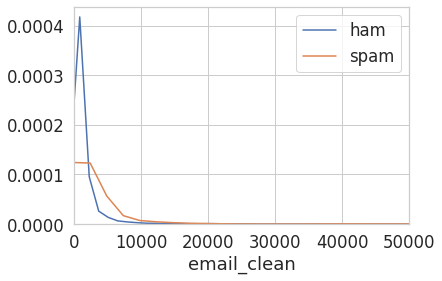

In [260]:
#looking to see if there is a distinguishing factor b/w ham and spam 
#using the word counts of the emails
ham = train[train['spam']==0]
spam = train[train['spam']==1]
ham_len = ham['email_clean'].str.len()
spam_len = spam['email_clean'].str.len()
sns.distplot(ham_len, label = 'ham', hist=False)
sns.distplot(spam_len, label = 'spam', hist=False)
plt.legend()
plt.xlim(0, 50000)


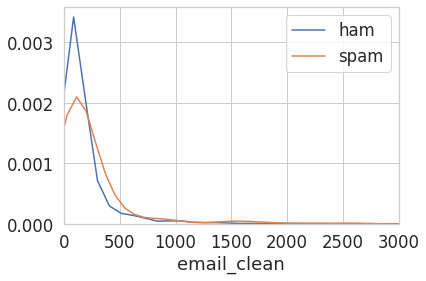

In [261]:
#looking to see if there is a distinguishing factor b/w ham and spam 
#number of word characters in body
ham_word = ham['email_clean'].str.findall('\w+').str.len()
spam_word = spam['email_clean'].str.findall('\w+').str.len()
sns.distplot(ham_word, label = 'ham', hist = False)
sns.distplot(spam_word, label = 'spam', hist = False)
plt.xlim(0, 3000)
plt.legend()


(2.0875781948168006, 6.470281543274244)

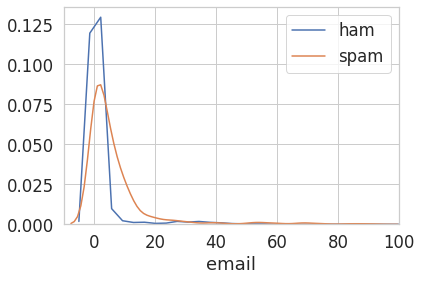

In [262]:
#checking if the number of exclamation marks are different. 
ham_punc = ham['email'].str.findall('\!').str.len()
spam_punc = spam['email'].str.findall('\!').str.len()
sns.distplot(ham_punc, label = 'ham',hist = False)
sns.distplot(spam_punc, label = 'spam', hist= False)
plt.xlim(-10, 100)
plt.legend()
np.average(ham_punc), np.average(spam_punc)

(16.11974977658624, 21.325860271115747)

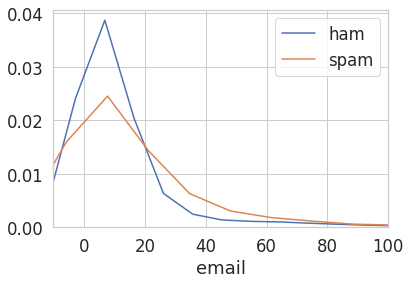

In [263]:
#checking if the number of commas are different. 
ham_punc = ham['email'].str.findall('\,').str.len()
spam_punc = spam['email'].str.findall('\,').str.len()
sns.distplot(ham_punc, label = 'ham',hist = False)
sns.distplot(spam_punc, label = 'spam', hist= False)
plt.xlim(-10, 100)
plt.legend()
np.average(ham_punc), np.average(spam_punc)

(1.860053619302949, 1.6579770594369134)

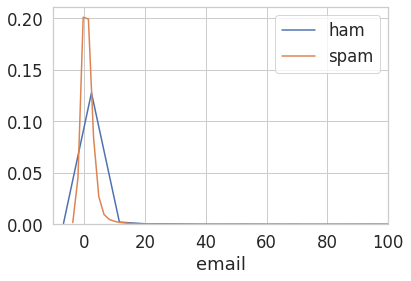

In [264]:
#checking if the number of @ are different. 
ham_punc = ham['email'].str.findall('\@').str.len()
spam_punc = spam['email'].str.findall('\@').str.len()
sns.distplot(ham_punc, label = 'ham',hist = False)
sns.distplot(spam_punc, label = 'spam', hist= False)
plt.xlim(-10, 100)
plt.legend()
np.average(ham_punc), np.average(spam_punc)

(1.3978552278820375, 3.9739311783107403)

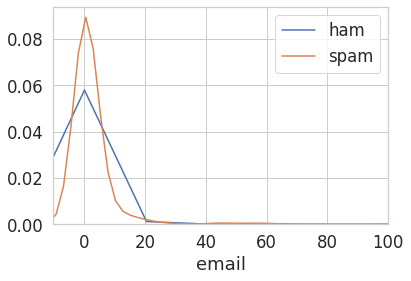

In [265]:
#checking if the number of @ are different. 
ham_punc = ham['email'].str.findall('\$').str.len()
spam_punc = spam['email'].str.findall('\$').str.len()
sns.distplot(ham_punc, label = 'ham',hist = False)
sns.distplot(spam_punc, label = 'spam', hist= False)
plt.xlim(-10, 100)
plt.legend()
np.average(ham_punc), np.average(spam_punc)

(0.05379803395889187, 0.4916579770594369)

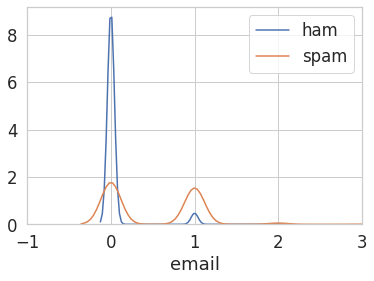

In [266]:
ham_html = ham['email'].str.findall(r"(\<html\>)").str.len()
spam_html = spam['email'].str.findall(r"(\<html\>)").str.len()
sns.distplot(ham_html, label = 'ham',hist = False)
sns.distplot(spam_html, label = 'spam', hist= False)
plt.xlim(-1, 3)
plt.legend()
np.average(ham_html), np.average(spam_html)

(4.149597855227882, 3.240354535974974)

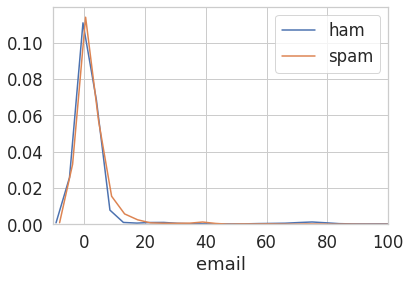

In [267]:
ham_www = ham['email'].str.findall("(www)").str.len()
spam_www = spam['email'].str.findall("(www)").str.len()
sns.distplot(ham_www, label = 'ham',hist = False)
sns.distplot(spam_www, label = 'spam', hist= False)
plt.xlim(-10, 100)
plt.legend()
np.average(ham_www), np.average(spam_www)

(7.702591599642538, 6.094890510948905)

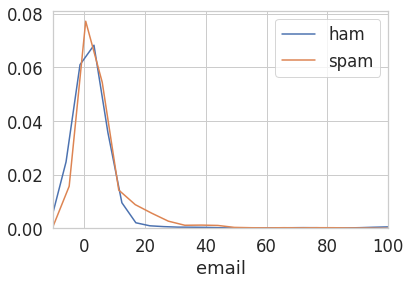

In [268]:
ham_http = ham['email'].str.findall("(http)").str.len()
spam_http = spam['email'].str.findall("(http)").str.len()
sns.distplot(ham_http, label = 'ham',hist = False)
sns.distplot(spam_http, label = 'spam', hist= False)
plt.xlim(-10, 100)
plt.legend()
np.average(ham_http), np.average(spam_http)

In [269]:
#looking at the most frequet words in both set
from collections import Counter 
Counter(" ".join(spam["email_clean"]).split()).most_common(25),Counter(" ".join(ham["email_clean"]).split()).most_common(25)

([('20', 6437),
  ('will', 3409),
  ('s', 3241),
  ('3e', 3136),
  ('free', 2797),
  ('email', 2747),
  ('3d', 2627),
  ('1', 2611),
  ('e', 2409),
  ('000', 2200),
  ('mail', 1996),
  ('click', 1919),
  ('please', 1892),
  ('t', 1856),
  ('money', 1757),
  ('list', 1696),
  ('business', 1680),
  ('3c', 1675),
  ('2', 1672),
  ('one', 1638),
  ('us', 1580),
  ('5', 1557),
  ('information', 1451),
  ('now', 1381),
  ('content', 1367)],
 [('s', 12688),
  ('09', 11721),
  ('t', 7081),
  ('1', 5996),
  ('2002', 5568),
  ('0', 5516),
  ('list', 5043),
  ('net', 5042),
  ('2', 4460),
  ('linux', 4204),
  ('will', 4015),
  ('d', 4003),
  ('one', 3649),
  ('new', 3169),
  ('use', 3044),
  ('lists', 3043),
  ('users', 2865),
  ('listinfo', 2769),
  ('now', 2677),
  ('html', 2665),
  ('m', 2660),
  ('time', 2604),
  ('20', 2579),
  ('font', 2523),
  ('3', 2505)])

(0.04330747651004435, 0.11048858529597128)

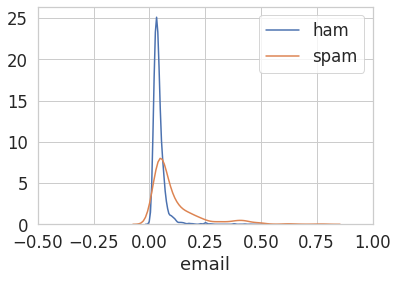

In [270]:
#proportion of capital letters
orig = pd.read_csv('data/train.csv')
ham_orig = orig[orig['spam']==0]
spam_orig = orig[orig['spam']==1]
ham_cap = ham_orig['email'].str.findall(r'[A-Z]').str.len()
spam_cap = spam_orig['email'].str.findall(r'[A-Z]').str.len()
ham_cap_prop = ham_cap/ ham_orig['email'].str.len()
spam_cap_prop = spam_cap/ spam_orig['email'].str.len()
sns.distplot(ham_cap_prop, label = 'ham',hist = False)
sns.distplot(spam_cap_prop, label = 'spam', hist= False)
plt.xlim(-0.5, 1)
plt.legend()
np.average(ham_cap_prop), np.average(spam_cap_prop)

(0.04330747651004435, 0.11048858529597128)

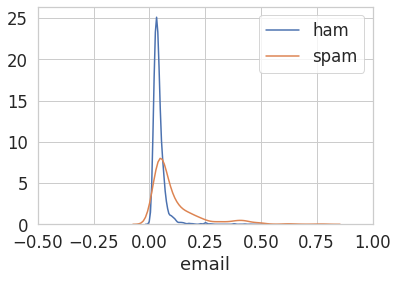

In [271]:
#proportion of capital letters
orig = pd.read_csv('data/train.csv')
orig['subject'] = orig['subject'].fillna('')
ham_orig = orig[orig['spam']==0]
spam_orig = orig[orig['spam']==1]
ham_cap = ham_orig['email'].str.findall(r'[A-Z]').str.len()
spam_cap = spam_orig['email'].str.findall(r'[A-Z]').str.len()
ham_cap_prop = ham_cap/ ham_orig['email'].str.len()
spam_cap_prop = spam_cap/ spam_orig['email'].str.len()
sns.distplot(ham_cap_prop, label = 'ham',hist = False)
sns.distplot(spam_cap_prop, label = 'spam', hist= False)
plt.xlim(-0.5, 1)
plt.legend()
np.average(ham_cap_prop), np.average(spam_cap_prop)

In [272]:
def prop_capital(df,col):
    cap = df[col].str.findall(r'[A-Z]').str.len()
    prop_cap = cap/ df[col].str.len()
    return prop_cap
prop_capital(orig, 'email')

0       0.061281
1       0.064748
2       0.114865
3       0.017333
4       0.044599
          ...   
8343    0.038041
8344    0.025839
8345    0.230420
8346    0.136247
8347    0.042874
Name: email, Length: 8348, dtype: float64

Text(0.5, 1.0, 'Most frequent words in spam email')

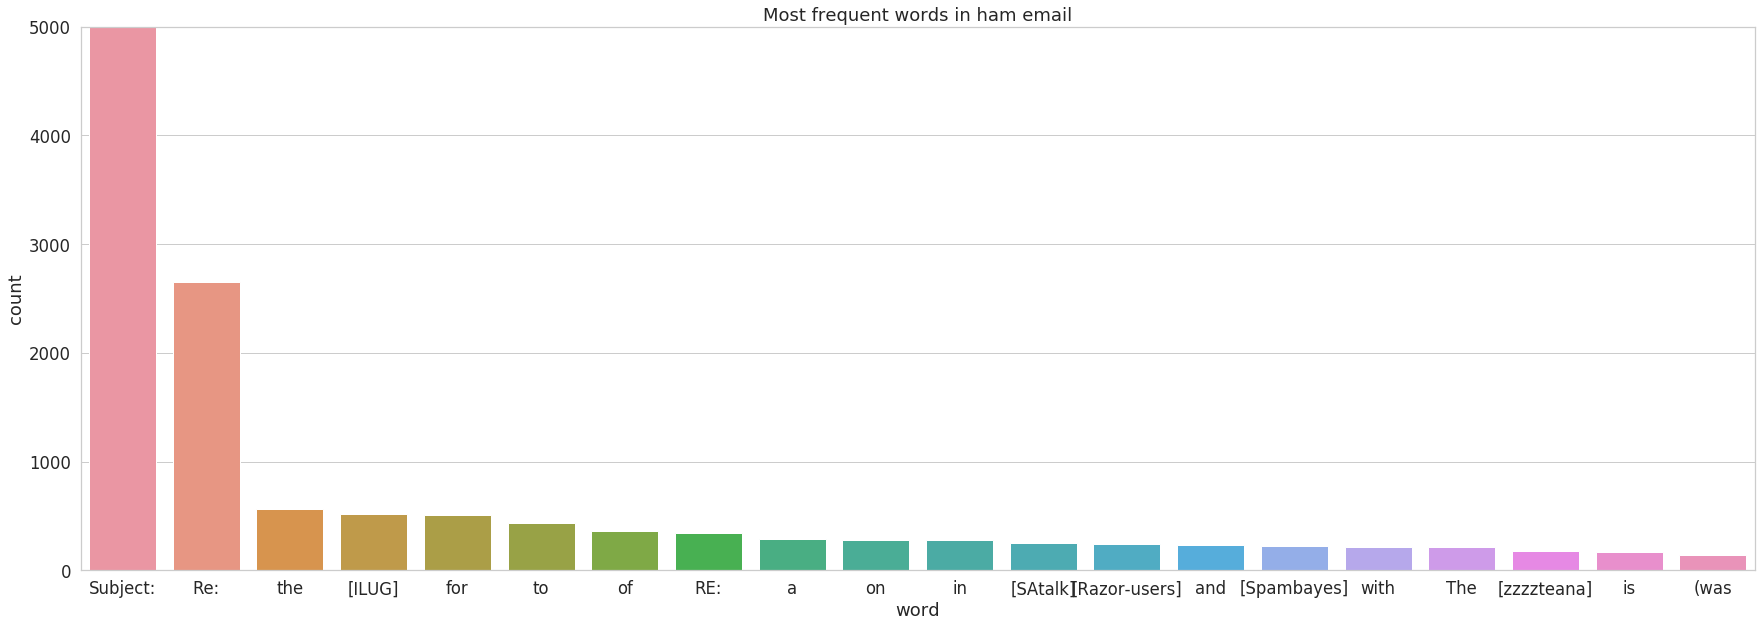

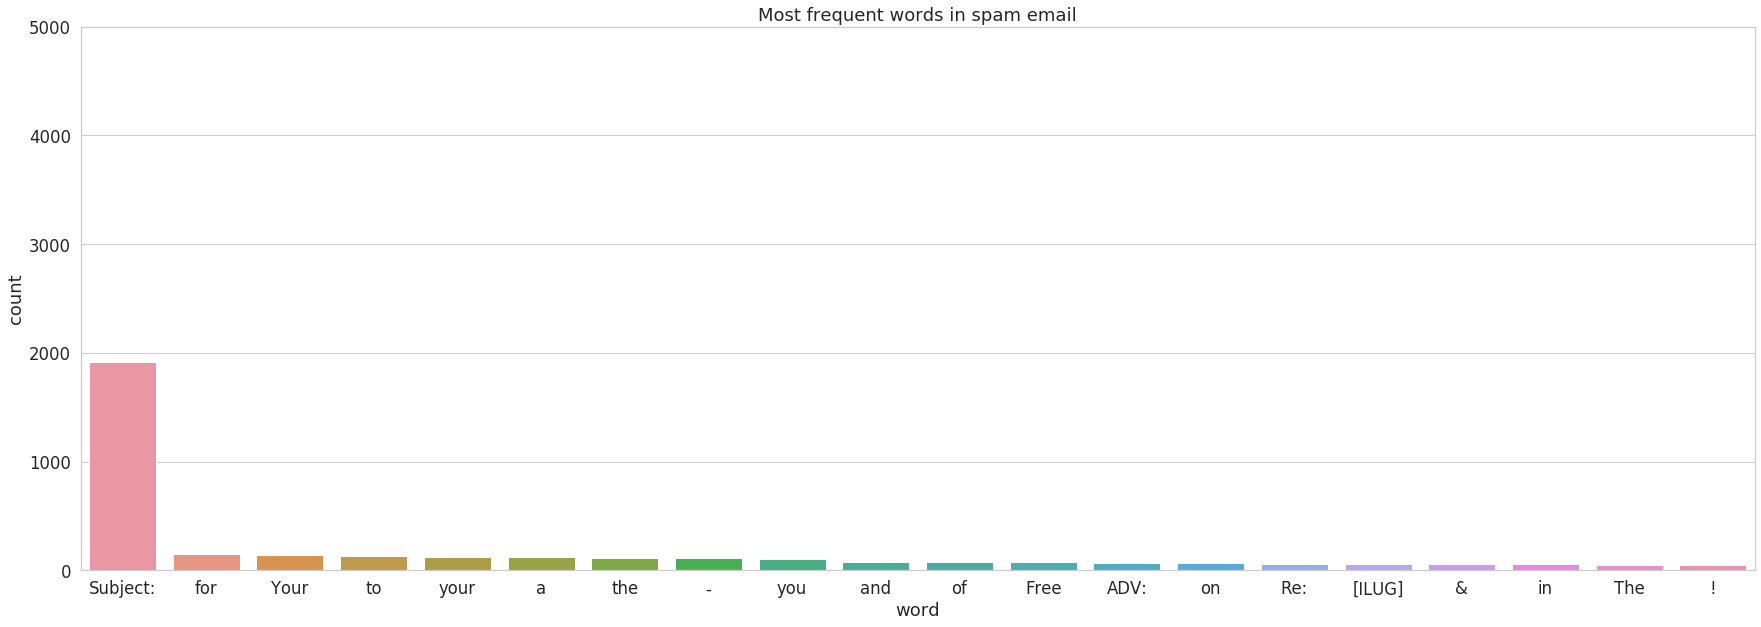

In [273]:

ham_common = dict(Counter(" ".join(ham["subject"]).split()).most_common(20))
ham_common_series = pd.Series(ham_common, name='count')
ham_common_series.index.name = 'word'
ham_common_series = ham_common_series.reset_index()
ham_common_series

spam_common = dict(Counter(" ".join(spam["subject"]).split()).most_common(20))
spam_common_series = pd.Series(spam_common, name='count')
spam_common_series.index.name = 'word'
spam_common_series = spam_common_series.reset_index()
spam_common_series

fig = plt.figure(figsize=(30,10))
plt.ylim(0,5000)
sns.barplot(x=ham_common_series['word'],y=ham_common_series['count'], data=ham_common_series)
plt.title('Most frequent words in ham email')

fig = plt.figure(figsize=(30,10))
plt.ylim(0,5000)
sns.barplot(x=spam_common_series['word'],y=spam_common_series['count'], data=spam_common_series)
plt.title('Most frequent words in spam email')

In [291]:
def feature(data,words):
    data= data.reset_index(drop=True) 
    tmp = words_in_texts(words, data['email'])
    df = pd.DataFrame(data = tmp, columns = words)
    data['subject'] = data['subject'].fillna('')
    df['subject_exc'] = data['subject'].str.count('!')
    df['prop_capital'] = data['subject'].str.findall(r'[A-Z]').str.len()/(data['subject'].str.len()+1)
    df['Respond'] = data['subject'].str.contains('Re')
    df['Forward'] = data['subject'].str.contains('Fw')
    df['exc'] = data['subject'].str.count('!')
    df['you'] = data['subject'].str.count('you')
    df['&'] = data['subject'].str.count('&')
    df['your'] = data['subject'].str.count('your')
    df['Your'] = data['subject'].str.count('Your')
    df['slength'] = data['subject'].str.len()
    df['swords'] = data['subject'].str.split().apply(len)
    df['sbye'] = data['subject'].str.count('bye')
    df['shi'] = data['subject'].str.count('hi')
    df['equals'] = data['subject'].str.count('=')
    df['sI'] = data['subject'].str.count('I')
    df['s['] = data['subject'].str.count('\[')
    df['s]'] = data['subject'].str.count('\]')
    df['s,'] = data['subject'].str.count(',')
    df['sm'] = data['subject'].str.count('month')
    df['sf'] = data['subject'].str.count('FREE')
    df['body_words'] = data['email'].str.split().apply(len)
    return df

In [292]:
some_words = ['!', '@', '<html>','<head>', '$', 'money', 'drug', 'dear','com', 'please', 'click', 'cheap', 'customer',
              'offer', 'url','20', '3d', 'us', 'company', 'job', 'increase', 'guarantee', 'hi', 'chance', 'your',
        ]

X_train = feature(train, some_words)
Y_train = train['spam']
x_test =  feature(val, some_words)
y_test = val['spam']
X_train[:5], Y_train[:5]
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
model.fit(X_train, Y_train)

training_accuracy = model.score(X_train, Y_train)
test_accuracy = model.score(x_test, y_test)
print("Training Accuracy: ", training_accuracy)
print('Test Accuracy:', test_accuracy)

Training Accuracy:  0.9402369226673766
Test Accuracy: 0.9449101796407186


### Feature and Model Selection

Describe the process of improving my model, below is my guide questions

1. How did you find better features for your model?
2. What did you try that worked / didn't work?
3. What was surprising in your search for good features?


1) I ran a bunch of distribution plots for certain features or words with spam vs ham to see if there was a major difference. I have looked into the elements of HTML tags , links and puncutations such as ! and @. Then to find the most frequent or best distinguishing words, I first cleaned the email by removing the punctutations, multiple spaces, line breaks, leading and trailing whitespace and stopwords (using csv file external). Then I have used the counter function to see which words popped up most frequently in the ham and in the spam emails. 

2) I tried to look into certain words that was one of the most frequent words in the ham email to see if that distinguished the email. However, in the distribution plot I saw that they were almost identical in their distribution, but the most frequent was shown because of the difference in the number of spam emails and ham emails. Moreover, I also looked into the number of characters of both categories, but it did not have much effect.

3) Some of the 'words' that I found as my feature was surprising, for example things like 'url', '20', '3d' increased the accuracy by quite a bit when I do not even know what they are even for in emails.I also found it surprising that without removing the stop words, the most frequent set of words are almost all stop words in both spam and ham emails. 


### EDA

show a visualization that you used to select features for your model. Including

1. A plot showing something meaningful about the data that helped you during feature selection, model selection, or both.
2. Two or three sentences describing what you plotted and its implications with respect to your features.


some ideas:

1. Consider the correlation between multiple features (look up correlation plots and `sns.heatmap`). 
1. Try to show redundancy in a group of features (e.g. `body` and `html` might co-occur relatively frequently, or you might be able to design a feature that captures all html tags and compare it to these). 
1. Visualize which words have high or low values for some useful statistic.
1. Visually depict whether spam emails tend to be wordier (in some sense) than ham emails.

Generate your visualization in the cell below and provide your description in a comment.

<!--
BEGIN QUESTION
name: q8
manual: True
format: image
points: 6
-->
<!-- EXPORT TO PDF format:image -->

Text(0.5, 1.0, 'Most frequent words in spam email')

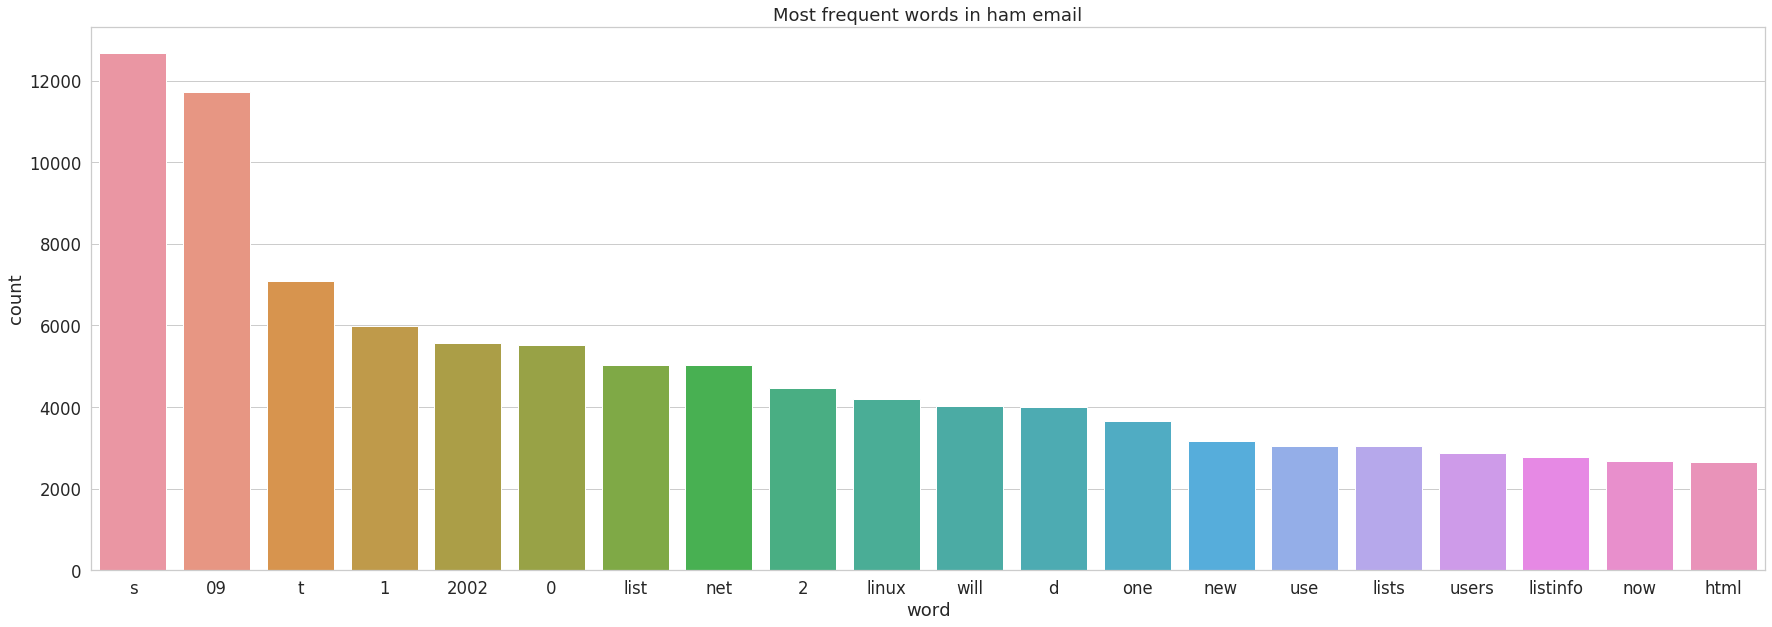

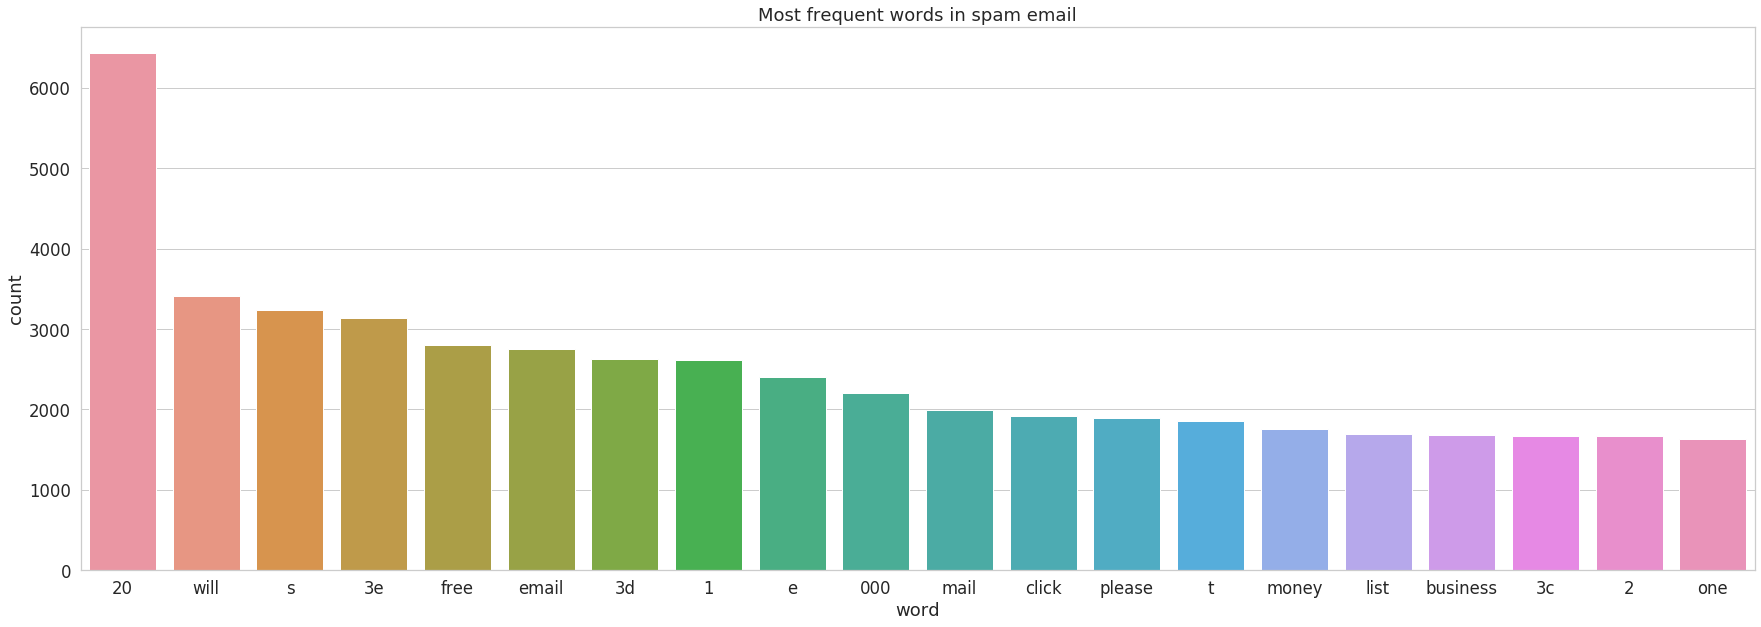

In [293]:
# Write your description (2-3 sentences) as a comment here:
# I have looked into the words that popped up most frequently in spam emails and in ham emails
# I have visualized the first 20 most common words in each category as a barplot of word agaisnt the counts
# I have used the most frequent words in spam emails, but not so in ham emails (or vice versa) as my feature word
# for example, we see words like 'free' and 'money' is very 'spammy' and appears a lot in spam emails, so i inlcuded them.


# Write the code to generate your visualization here:
ham_common = dict(Counter(" ".join(ham["email_clean"]).split()).most_common(20))
ham_common_series = pd.Series(ham_common, name='count')
ham_common_series.index.name = 'word'
ham_common_series = ham_common_series.reset_index()
ham_common_series

spam_common = dict(Counter(" ".join(spam["email_clean"]).split()).most_common(20))
spam_common_series = pd.Series(spam_common, name='count')
spam_common_series.index.name = 'word'
spam_common_series = spam_common_series.reset_index()
spam_common_series

fig = plt.figure(figsize=(30,10))
sns.barplot(x=ham_common_series['word'],y=ham_common_series['count'], data=ham_common_series)
plt.title('Most frequent words in ham email')

fig = plt.figure(figsize=(30,10))
sns.barplot(x=spam_common_series['word'],y=spam_common_series['count'], data=spam_common_series)
plt.title('Most frequent words in spam email')

### ROC Curve

In most cases we won't be able to get no false positives and no false negatives, so we have to compromise. For example, in the case of cancer screenings, false negatives are comparatively worse than false positives — a false negative means that a patient might not discover a disease until it's too late to treat, while a false positive means that a patient will probably have to take another screening.

Recall that logistic regression calculates the probability that an example belongs to a certain class. Then, to classify an example we say that an email is spam if our classifier gives it $\ge 0.5$ probability of being spam. However, *we can adjust that cutoff*: we can say that an email is spam only if our classifier gives it $\ge 0.7$ probability of being spam, for example. This is how we can trade off false positives and false negatives.

The ROC curve shows this trade off for each possible cutoff probability. In the cell below, plot an ROC curve for my final classifier (the one I use to make predictions for Kaggle).

(0.0, 1)

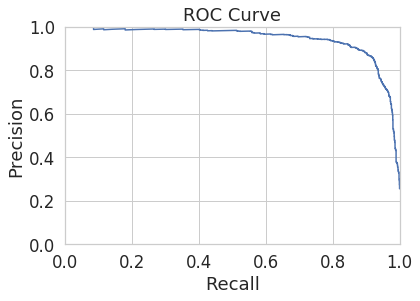

In [301]:
from sklearn.metrics import precision_recall_curve


cf = LogisticRegression(fit_intercept=True)
cf.fit(X_train, Y_train)
y_score = cf.predict_proba(X_train)[:,1]
precision, recall, thresholds = precision_recall_curve(Y_train, y_score)
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('ROC Curve')
plt.ylim([0.0, 1])
plt.xlim([0.0, 1])


Text(0.5, 1.0, 'ROC Curve')

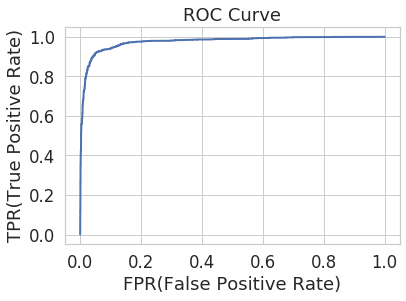

In [302]:
### from sklearn.metrics import roc_curve



predict_prob = model.predict_proba(X_train)
FPR, TPR, _ = roc_curve(Y_train, predict_prob[:,1])
plt.plot(FPR, TPR, lw=2)
plt.xlabel('FPR(False Positive Rate)')
plt.ylabel('TPR(True Positive Rate)')
plt.title('ROC Curve')

In [303]:
words =['!', '@', '<html>','<head>', '$', 'money', 'drug', 'dear','com', 'please', 'click', 'cheap', 'customer',
              'offer', 'url','20', '3d', 'us', 'company', 'job', 'increase', 'guarantee', 'hi', 'chance', 'your',
        ]
test_df = feature(test, words)
test_predictions = model.predict(test_df)

The following saves a file to submit to Kaggle.

In [307]:
from datetime import datetime

# Assuming that your predictions on the test set are stored in a 1-dimensional array called
# test_predictions. Feel free to modify this cell as long you create a CSV in the right format.

# Construct and save the submission:
submission_df = pd.DataFrame({
    "Id": test['id'], 
    "Class": test_predictions,
}, columns=['Id', 'Class'])
timestamp = datetime.isoformat(datetime.now()).split(".")[0]
submission_df.to_csv("submission_{}.csv".format(timestamp), index=False)

print('Created a CSV file: {}.'.format("submission_{}.csv".format(timestamp)))
print('You may now upload this CSV file to Kaggle for scoring.')

Created a CSV file: submission_2019-11-26T15:23:44.csv.
You may now upload this CSV file to Kaggle for scoring.
